**INSTALL AND IMPORT*


In [8]:
%pip install pandas numpy tensorflow logging transformers sklearn 
%pip install sentence-transformers nlpaug textaugment
import pandas as pd
import ast
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils import resample
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb
import matplotlib.pyplot as plt



  Using cached logging-0.4.9.6.tar.gz (96 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [19 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 14, in <module>
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\setuptools\__init__.py", line 16, in <module>
          import setuptools.version
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\setuptools\version.py", line 1, in <module>
          import pkg_resources
        File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\site-packages\pkg_resources\__init__.py", line 83, in <module>
          __import__('pkg_resources.extern.packaging.specifiers')
        File "C:\Program Files\WindowsApps\PythonSoftw


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: C:\Users\JT2ju\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


*FILTER DATA, NO NEED TO RUN*

Encoding with SBERT...


Batches: 100%|██████████| 269/269 [00:11<00:00, 24.20it/s]
C:\Users\JT2ju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JT2ju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [15:05:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\JT2ju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packa

🔍 Predicting...
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      2981
           1       0.73      0.08      0.14       104
           2       0.78      0.16      0.26        45
           3       1.00      0.31      0.47        13
           4       0.77      0.50      0.60       956
           5       0.71      0.05      0.09        99
           6       0.75      0.06      0.11       102

    accuracy                           0.78      4300
   macro avg       0.79      0.30      0.36      4300
weighted avg       0.78      0.78      0.74      4300



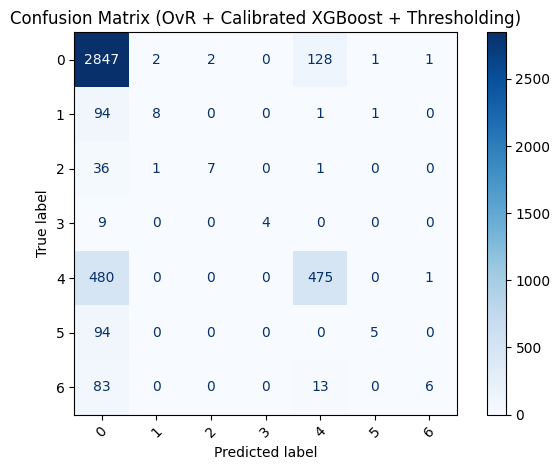

In [ ]:

#Preprocess data
def preprocess_data(dataset):
    dialogues, emotions = [], []
    for _, row in dataset.iterrows():
        try:
            dialogue = row["dialog"].strip("[|").strip("|]").split(" | ")
            emotion = eval(row["emotion"])
            if len(dialogue) == len(emotion):
                dialogues.extend(dialogue)
                emotions.extend(emotion)
        except:
            continue
    return dialogues, emotions

def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^\w\s.,!?]", "", text)
    return text.strip()

def oversample_rare_classes(X, y, boost_classes=[1, 2, 3, 5, 6], target_count=500):
    df = pd.DataFrame({'text': X, 'label': y})
    oversampled = [df[df.label == cls] for cls in df.label.unique() if cls not in boost_classes]
    for cls in boost_classes:
        cls_df = df[df.label == cls]
        upsampled = resample(cls_df, replace=True, n_samples=target_count, random_state=42)
        oversampled.append(upsampled)
    final_df = pd.concat(oversampled).sample(frac=1).reset_index(drop=True)
    return final_df['text'].tolist(), final_df['label'].tolist()

#Load filtered data
train_dataset = pd.read_csv(
    'Data/dd_train_best.csv',
    skiprows=1,
    names=["dialog", "act", "emotion"]
)
test_dataset = pd.read_csv(
    'Data/dd_test_best.csv',
    skiprows=1,
    names=["dialog", "act", "emotion"]
)

#Process
X_train_text, y_train = preprocess_data(train_dataset)
X_test_text, y_test = preprocess_data(test_dataset)

X_train_text = [clean_text(t) for t in X_train_text]
X_test_text = [clean_text(t) for t in X_test_text]

#Encode Labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
n_classes = len(label_encoder.classes_)

#Adjust for Oversample
X_train_text, y_train_encoded = oversample_rare_classes(X_train_text, y_train_encoded)

#SBERT
print("Encoding with SBERT...")
sbert = SentenceTransformer("paraphrase-MiniLM-L6-v2")
X_train_emb = sbert.encode(X_train_text, batch_size=16, show_progress_bar=True)
X_test_emb = sbert.encode(X_test_text, batch_size=16, show_progress_bar=True)

#One-vs-Rest Classifier with Calibration
base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    learning_rate=0.05,
    max_depth=6,
    n_estimators=300,
    use_label_encoder=False
)
ovr_model = OneVsRestClassifier(
    CalibratedClassifierCV(base_model, method='sigmoid', cv=3)
)

#Train
Y_train_bin = label_binarize(y_train_encoded, classes=np.arange(n_classes))
ovr_model.fit(X_train_emb, Y_train_bin)

#Predict
print("Predicting...")
y_proba = ovr_model.predict_proba(X_test_emb)
thresholds = [0.5, 0.3, 0.25, 0.3, 0.5, 0.3, 0.3]
y_pred = [np.argmax([p if p >= thresholds[i] else 0 for i, p in enumerate(prob)]) for prob in y_proba]

#Evaluate
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_.astype(str)))

cm = confusion_matrix(y_test_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)

#Plot
plt.title("Confusion Matrix (OvR + Calibrated XGBoost + Thresholding)")
plt.tight_layout()
plt.show()
